<img src='pics/otus.png'>

In [5]:
from __future__ import print_function
from collections import defaultdict
import pandas as pd
import numpy as np
import matplotlib
# import pandas_profiling
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

%matplotlib inline
plt.rcParams["figure.figsize"] = (8, 4)
pd.options.display.float_format = '{:.2f}'.format
pd.set_option('display.max_columns', 50)


In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegressionCV
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score, average_precision_score, precision_score, recall_score
from sklearn.cluster import KMeans

## 0. Рассматриваем "Breast Cancer Wisconsin (Diagnostic) Data Set"

In [8]:
df_source = pd.read_csv(r'data.csv') #/Users/mary/Desktop/Otus/Module 2/L15. PCA, T-sne/data.csv
df=df_source
df.head(3)

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.00,0.12,0.28,0.30,0.15,0.24,0.08,1.09,0.91,8.59,153.40,0.01,0.05,0.05,0.02,0.03,0.01,25.38,17.33,184.60,2019.00,0.16,0.67,0.71,0.27,0.46,0.12,nan
1,842517,M,20.57,17.77,132.90,1326.00,0.08,0.08,0.09,0.07,0.18,0.06,0.54,0.73,3.40,74.08,0.01,0.01,0.02,0.01,0.01,0.00,24.99,23.41,158.80,1956.00,0.12,0.19,0.24,0.19,0.28,0.09,nan
2,84300903,M,19.69,21.25,130.00,1203.00,0.11,0.16,0.20,0.13,0.21,0.06,0.75,0.79,4.58,94.03,0.01,0.04,0.04,0.02,0.02,0.00,23.57,25.53,152.50,1709.00,0.14,0.42,0.45,0.24,0.36,0.09,nan


# 1. EDA
Просмотреть структуру данных, значения каждого признака, поискать особенности в признаках и в данных в целом

In [461]:
df.shape

(569, 33)

In [435]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
id                         569 non-null int64
diagnosis                  569 non-null object
radius_mean                569 non-null float64
texture_mean               569 non-null float64
perimeter_mean             569 non-null float64
area_mean                  569 non-null float64
smoothness_mean            569 non-null float64
compactness_mean           569 non-null float64
concavity_mean             569 non-null float64
concave points_mean        569 non-null float64
symmetry_mean              569 non-null float64
fractal_dimension_mean     569 non-null float64
radius_se                  569 non-null float64
texture_se                 569 non-null float64
perimeter_se               569 non-null float64
area_se                    569 non-null float64
smoothness_se              569 non-null float64
compactness_se             569 non-null float64
concavity_se               569 non

Уже из полученной информации можем убрать столбец Unnamed:32, поскольку в нем нигде нет значений. И теперь пропуски можем не обрабатывать, т.к. их нет. Также, присутствует фича типа "объект" - диагноз: M = malignant (признак злокачественности опухоли), B = benign (признак доброкачественности). Ее необходимо будет закодировать

In [366]:
df.groupby('diagnosis')['id'].count()

diagnosis
B    357
M    212
Name: id, dtype: int64

Возможные классы сбаллансированны. В выборке примерно 60% одгоно и 40% другого классов

In [305]:
df.describe()

,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
count,569.00,569.00,569.00,569.00,569.00,569.00,569.00,569.00,569.00,569.00,569.00,569.00,569.00,569.00,569.00,569.00,569.00,569.00,569.00,569.00,569.00,569.00,569.00,569.00,569.00,569.00,569.00,569.00,569.00,569.00,569.00,0.00
mean,30371831.43,14.13,19.29,91.97,654.89,0.10,0.10,0.09,0.05,0.18,0.06,0.41,1.22,2.87,40.34,0.01,0.03,0.03,0.01,0.02,0.00,16.27,25.68,107.26,880.58,0.13,0.25,0.27,0.11,0.29,0.08,nan
std,125020585.61,3.52,4.30,24.30,351.91,0.01,0.05,0.08,0.04,0.03,0.01,0.28,0.55,2.02,45.49,0.00,0.02,0.03,0.01,0.01,0.00,4.83,6.15,33.60,569.36,0.02,0.16,0.21,0.07,0.06,0.02,nan
min,8670.00,6.98,9.71,43.79,143.50,0.05,0.02,0.00,0.00,0.11,0.05,0.11,0.36,0.76,6.80,0.00,0.00,0.00,0.00,0.01,0.00,7.93,12.02,50.41,185.20,0.07,0.03,0.00,0.00,0.16,0.06,nan
25%,869218.00,11.70,16.17,75.17,420.30,0.09,0.06,0.03,0.02,0.16,0.06,0.23,0.83,1.61,17.85,0.01,0.01,0.02,0.01,0.02,0.00,13.01,21.08,84.11,515.30,0.12,0.15,0.11,0.06,0.25,0.07,nan
50%,906024.00,13.37,18.84,86.24,551.10,0.10,0.09,0.06,0.03,0.18,0.06,0.32,1.11,2.29,24.53,0.01,0.02,0.03,0.01,0.02,0.00,14.97,25.41,97.66,686.50,0.13,0.21,0.23,0.10,0.28,0.08,nan
75%,8813129.00,15.78,21.80,104.10,782.70,0.11,0.13,0.13,0.07,0.20,0.07,0.48,1.47,3.36,45.19,0.01,0.03,0.04,0.01,0.02,0.00,18.79,29.72,125.40,1084.00,0.15,0.34,0.38,0.16,0.32,0.09,nan
max,911320502.00,28.11,39.28,188.50,2501.00,0.16,0.35,0.43,0.20,0.30,0.10,2.87,4.88,21.98,542.20,0.03,0.14,0.40,0.05,0.08,0.03,36.04,49.54,251.20,4254.00,0.22,1.06,1.25,0.29,0.66,0.21,nan


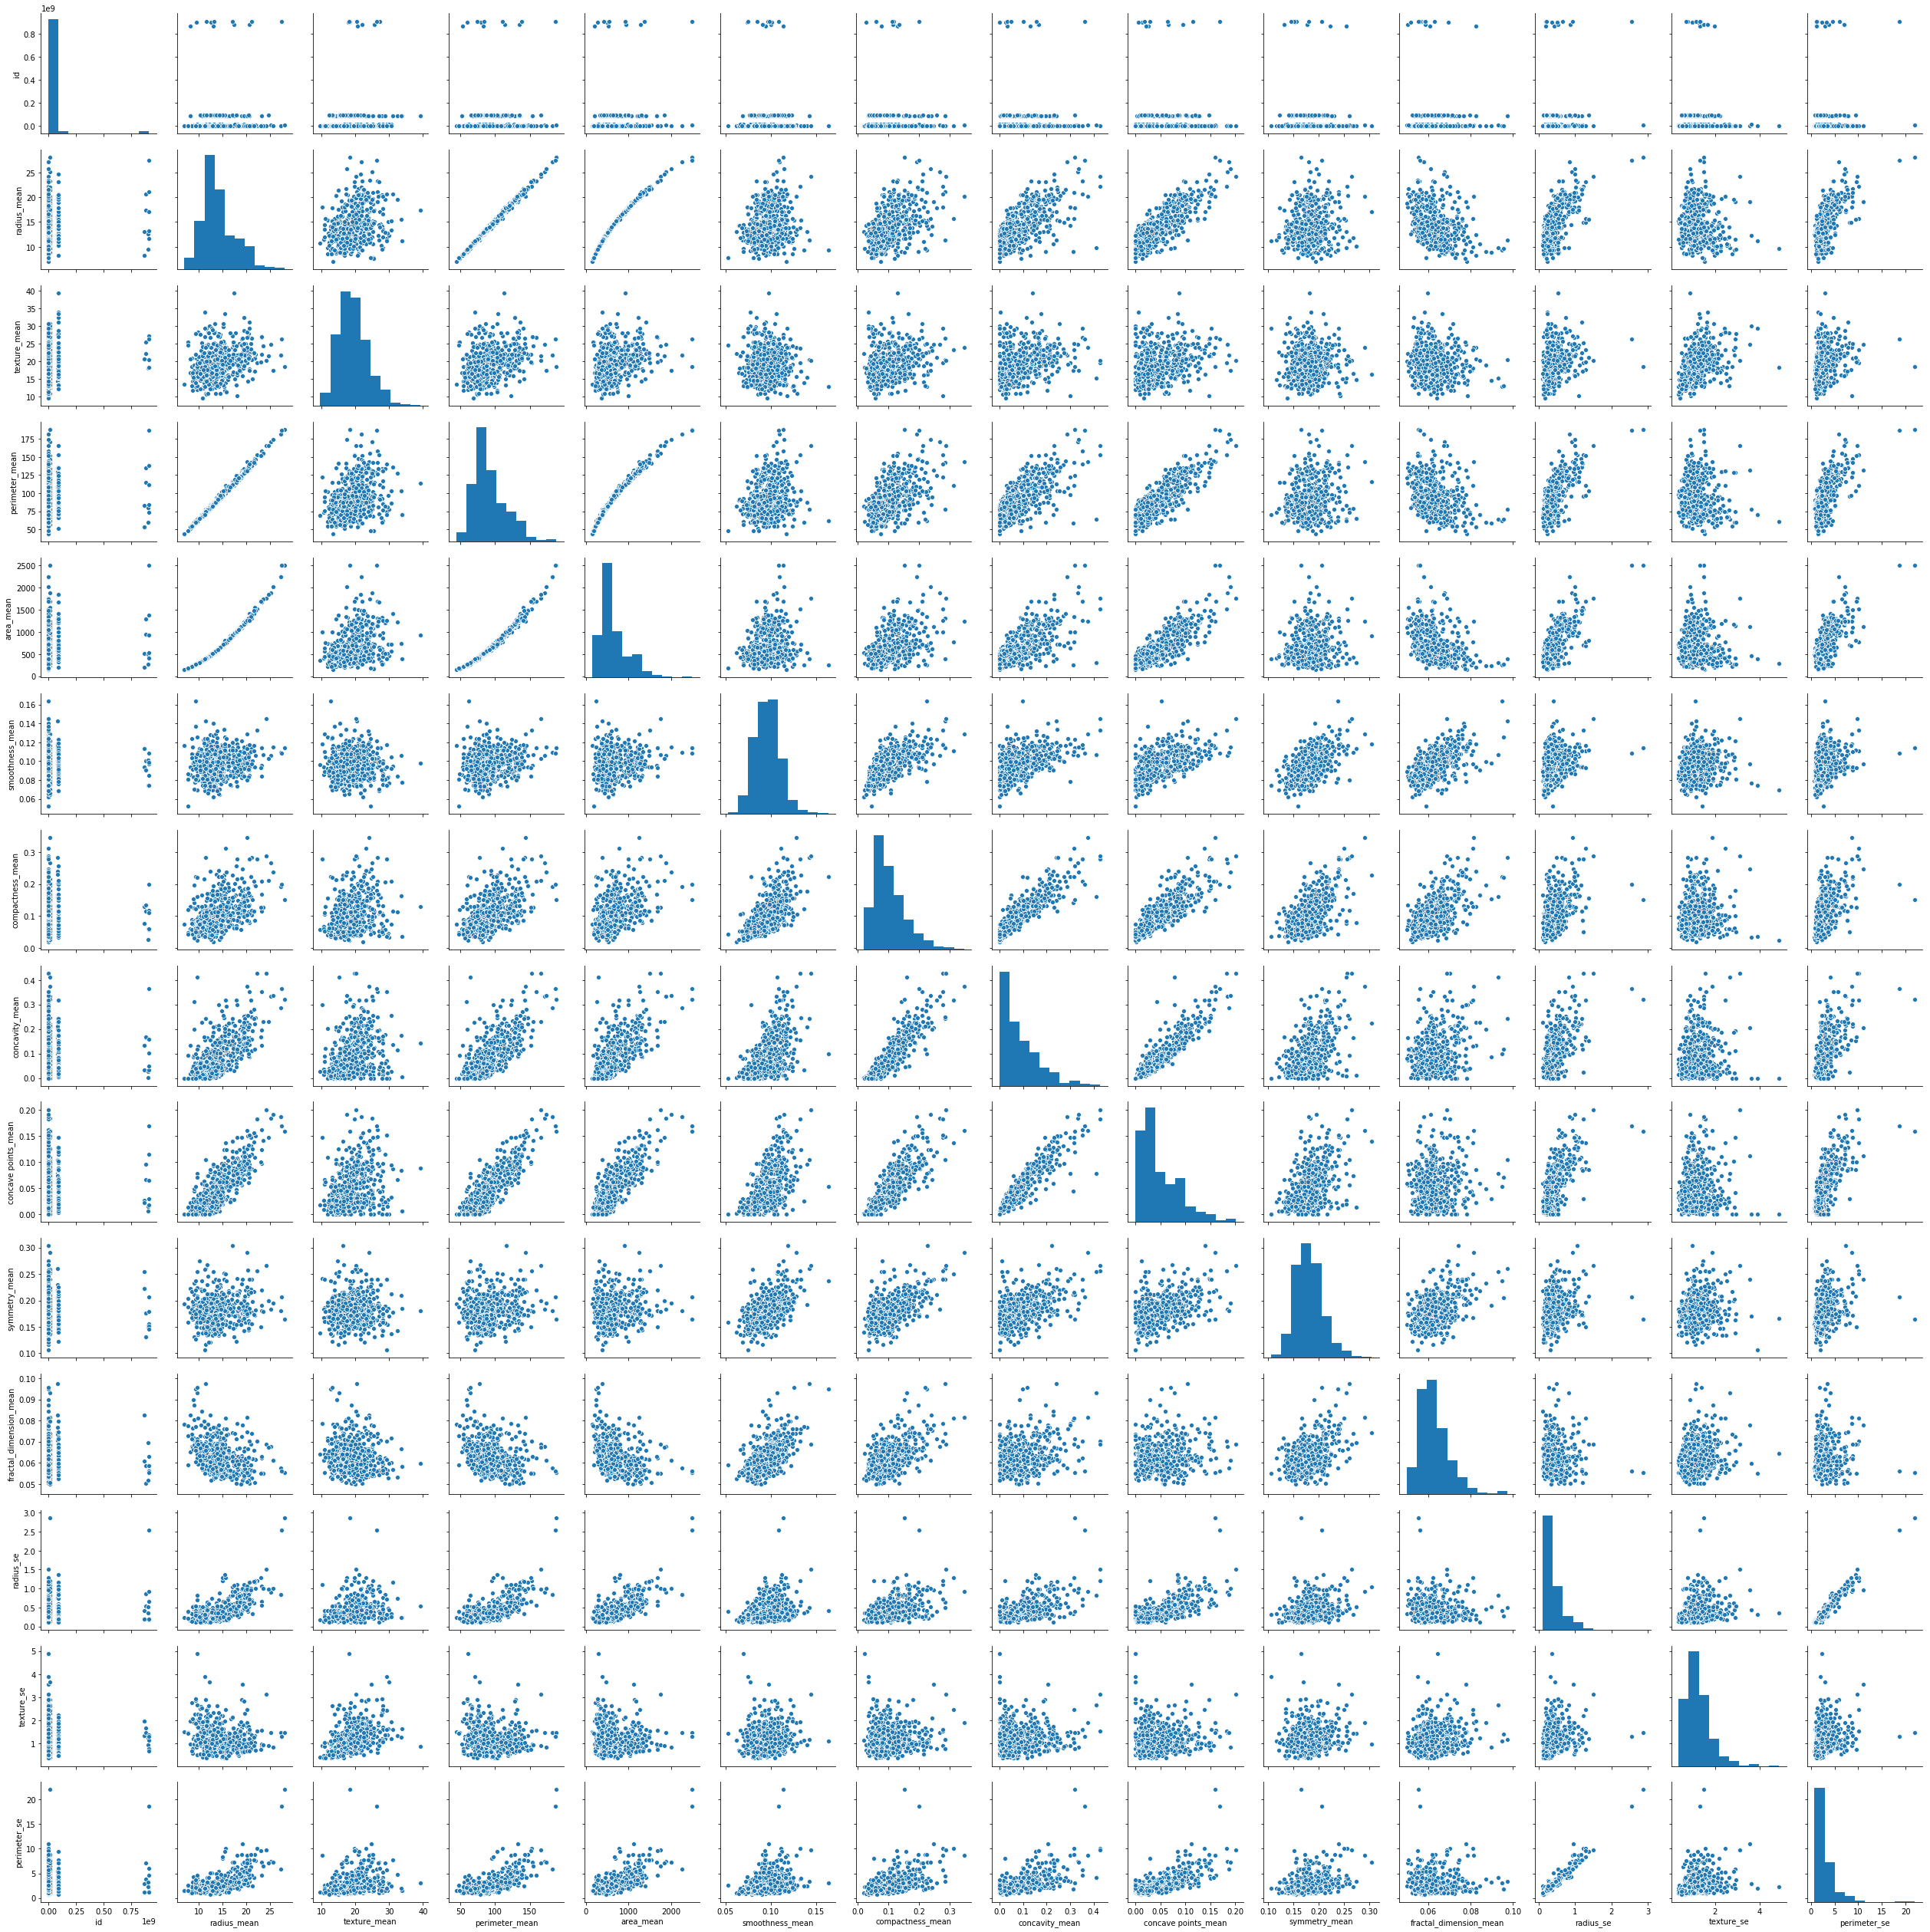

In [306]:
sns.pairplot(df.iloc[:, :15])

Поскольку фич много, pairplot смотреть неудобно уже для 15 фич, но четкая зависимость между некоторыми из них уже видна. Посмотрим на наличие линейной зависимости на тепловой карте

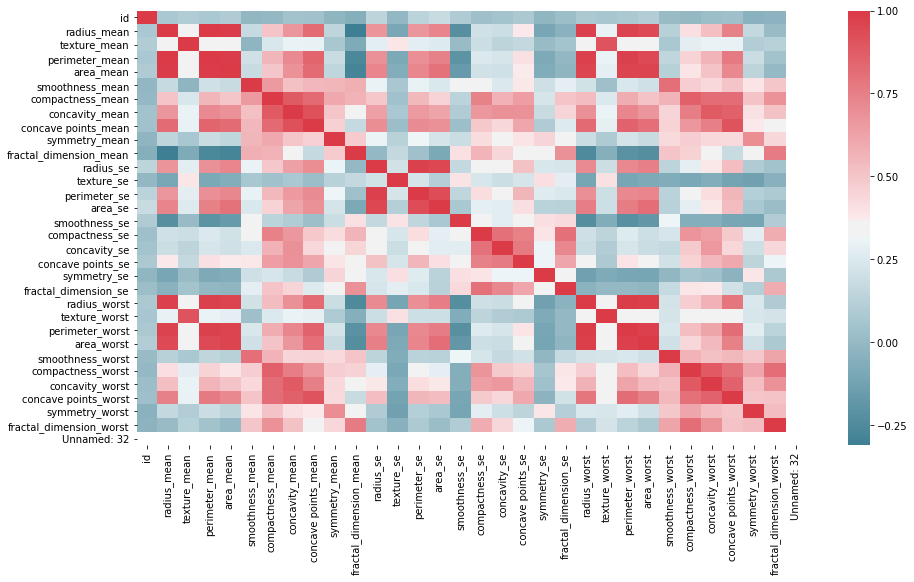

In [49]:
plt.figure(figsize=(15,8))
sns.heatmap(df.corr(),annot=False, cmap=sns.diverging_palette(220, 10, as_cmap=True));

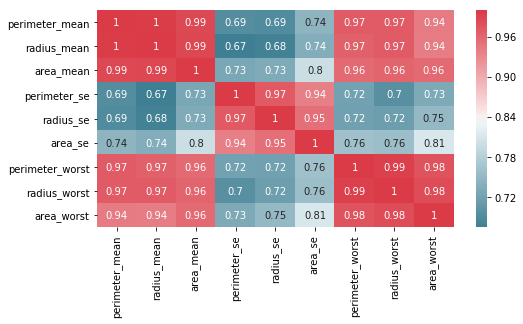

In [50]:
sns.heatmap(df[['perimeter_mean', 
                'radius_mean', 
                'area_mean',
                'perimeter_se', 
                'radius_se', 
                'area_se', 
                'perimeter_worst', 
                'radius_worst', 
                'area_worst']].corr()
            ,annot=True, cmap=sns.diverging_palette(220, 10, as_cmap=True)
           );

Между некоторыми фичами есть сильная корреляция (например: area, radius, perimeter - worst, se и mean), что значит, что часть из этих фич желательно убрать, либо преобразовать

(569, 13)


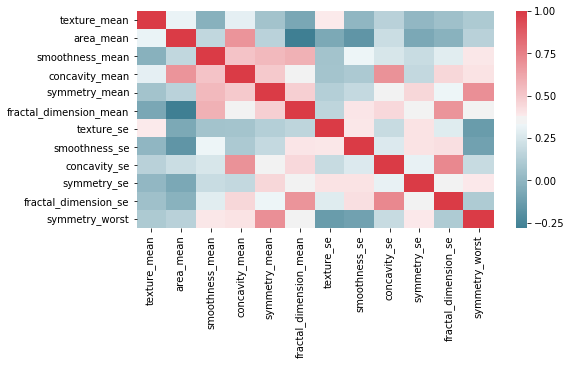

In [51]:
experiment = df.drop(['Unnamed: 32', 
                    'id', 
                     'perimeter_mean', 
                     'radius_mean',
                     'perimeter_se', 
                     'radius_se', 
                     'area_se', 
                     'perimeter_worst', 
                     'radius_worst', 
                     'area_worst',
                    'concave points_mean', 
                    'compactness_mean', 
                    'concave points_worst', 
                    'compactness_worst', 
                    'concavity_worst', 
                    'compactness_se', 
                    'concave points_se',
                    'smoothness_worst',
                    'texture_worst',
                    'fractal_dimension_worst'
                   ], axis=1)
sns.heatmap(experiment.corr(),annot=False, cmap=sns.diverging_palette(220, 10, as_cmap=True));
print(experiment.shape)

# 2. План эксперимента 


* Применить Encoder к признаку "диагноз", отнормировать признаки
* Убрать сильно коррелирующие признаки, добавить полиномиальные
* Применить понижение размерности для визуализации данных (TSNE)
* Применить кластеризацию, визуализировать
* Описание кластера

# 3. Подготовка данных для построения модели


Уберем из признаков полностью нулевой столбец 'Unnamed: 32', поскольку он не несет никакой информации. 

Также уберем корреллирующие признаки.

In [10]:
#  for clustering
diagnosis = df['diagnosis']
features_after_drop = df.drop(['Unnamed: 32', 
                    'id', 
                    'diagnosis',
                     'perimeter_mean', 
                     'radius_mean',
                     'perimeter_se', 
                     'radius_se', 
                     'area_se', 
                     'perimeter_worst', 
                     'radius_worst', 
                     'area_worst',
                    'concave points_mean', 
                    'compactness_mean', 
                    'concave points_worst', 
                    'compactness_worst', 
                    'concavity_worst', 
                    'compactness_se', 
                    'concave points_se',
                    'smoothness_worst',
                    'texture_worst',
                    'fractal_dimension_worst'
                   ], axis=1)

diagnosis = LabelEncoder().fit_transform(diagnosis)
features = StandardScaler().fit_transform(features_after_drop)
features_poly = PolynomialFeatures().fit_transform(features)

# features_all = df.drop(['Unnamed: 32', 'id', 'diagnosis'], axis=1)
# features_all = StandardScaler().fit_transform(features_all)
# features_all = PolynomialFeatures().fit_transform(features_all)

In [11]:
features_poly.shape , features_all.shape

((569, 91), (569, 496))

# 4. Построение модели 

Построим визуализации работы TSNE для фичей, отобранных вручную и для них же, но с добавлением полиномиальных.

##### 1. Отобранные вручную

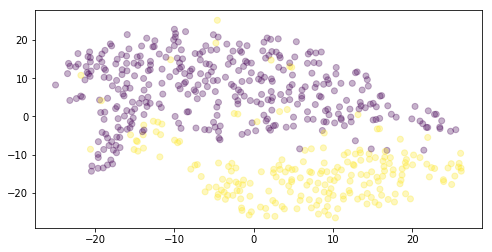

In [16]:
tsne = TSNE(n_components=2, random_state=42)
X_reduced = tsne.fit_transform(features)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=diagnosis, alpha=0.3);

Посмотрим результаты KMeans кластеризации для данного случая и выведем roc_auc для TSNE без полиномиальных фичей

0.1801014372372826


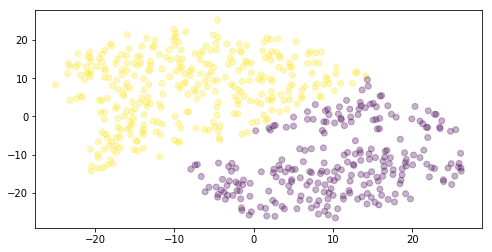

In [17]:
kmeans_tsne = KMeans(n_clusters=2, random_state=0).fit(X_reduced)
tsne_labels = kmeans_tsne.labels_
print(roc_auc_score(tsne_labels, diagnosis))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=tsne_labels, alpha=0.3);

Получили roc auc < 50%. Однако это же значит, что инвертируя наши предсказания, скор roc auc составит 82% (необходимо просто поменять местами 1 и 0 в результатах кластеризации)

0.8198985627627174


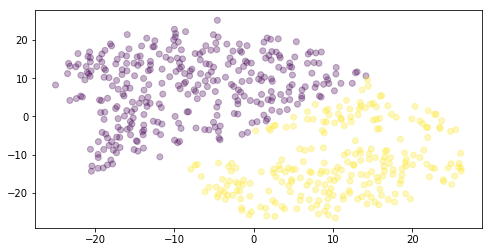

In [30]:
tsne_labels_invert = pd.Series(kmeans_tsne.labels_).apply(lambda x: 1 if x==0 else 0)
print(roc_auc_score(tsne_labels_invert, diagnosis))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=tsne_labels_invert, alpha=0.3);

##### 2. Отобранные вручную + полиномиальные

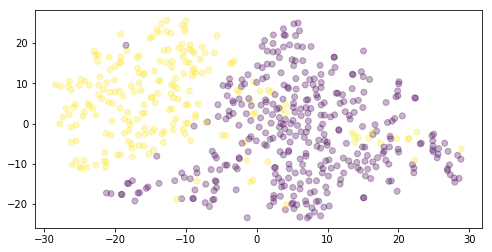

In [18]:
tsne = TSNE(n_components=2, random_state=45)
X_reduced_poly = tsne.fit_transform(features_poly)
plt.scatter(X_reduced_poly[:, 0], X_reduced_poly[:, 1], c=diagnosis, alpha=0.3);

0.8081802383316782


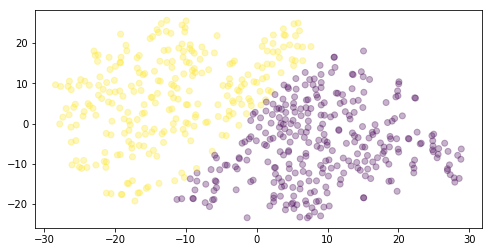

In [20]:
kmeans_tsne_poly = KMeans(n_clusters=2, random_state=0).fit(X_reduced_poly)
tsne_poly_labels = kmeans_tsne_poly.labels_
print(roc_auc_score(tsne_poly_labels, diagnosis))
plt.scatter(X_reduced_poly[:, 0], X_reduced_poly[:, 1], c=tsne_poly_labels, alpha=0.3);

Видно, что разделение на возможные классы прошло хорошо в обоих случаях: классы разделимы (с некоторым зашумлением). Однако в первом случае roc auc после применения KMeans дал 18%, а во втором 81%. Однако при инвертировании кластеров в первом случае получим результат лучше на 1%: 82%. Кластеризация с TSNE для фичей без полиномиальных отработала лучше. 

Попробуем сократить размерность при помощи PCA. Сначала для отобранных 12 фич + полиномиальные, затем для отобранных 12

(569, 91)
48
25


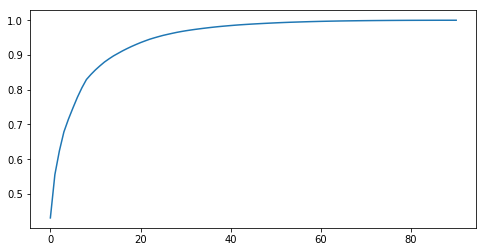

In [94]:
pca_poly = PCA(random_state=45)
pca_poly.fit(features_poly)
cumsum = np.cumsum(pca_poly.explained_variance_ratio_)
plt.plot(cumsum);

print(features_poly.shape)
print(np.argmax(cumsum >= 0.99) + 1)
print(np.argmax(cumsum >= 0.95) + 1)

Для того, чтобы объяснить 99% дисперсии данных необходимо взять 48 фич, попробуем это сделать:

In [97]:
pca_poly = PCA(48, random_state=45).fit_transform(features_poly)
kmeans_pca_poly = KMeans(n_clusters=2, random_state=0).fit(pca_poly)
print(roc_auc_score(kmeans_pca_poly.labels_, diagnosis))

0.31338028169014087


Для первого варианта получили неудовлетворительный результат

(569, 12)
11
9


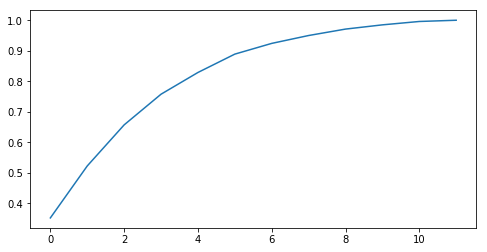

In [98]:
pca = PCA(random_state=45)
pca.fit(features)
cumsum = np.cumsum(pca.explained_variance_ratio_)
plt.plot(cumsum);

print(features.shape)
print(np.argmax(cumsum >= 0.99) + 1)
print(np.argmax(cumsum >= 0.95) + 1)

In [99]:
pca = PCA(11, random_state=45).fit_transform(features)
kmeans_pca = KMeans(n_clusters=2, random_state=0).fit(pca)
print(roc_auc_score(kmeans_pca.labels_, diagnosis))

0.26012960142532826


Для второго варианта также неудовлетворительный результат

# 5. Проанализировать результат


Результат работы TSNE (лучший из вариантов)

In [31]:
# features_after_drop['tsne_labels'] = tsne_labels
# features_after_drop.groupby('tsne_labels').agg({'mean','min','max'})

features_after_drop['tsne_labels'] = tsne_labels_invert
features_after_drop.groupby('tsne_labels').agg({'mean','min','max'})

texture_mean             area_mean               smoothness_mean  \
                     max   min  mean       max    min   mean             max   
tsne_labels                                                                    
0                  33.81  9.71 18.12    998.90 181.00 505.91            0.13   
1                  39.28 10.38 20.83   2501.00 143.50 850.49            0.16   

                      concavity_mean           symmetry_mean            \
             min mean            max  min mean           max  min mean   
tsne_labels                                                              
0           0.05 0.09           0.14 0.00 0.04          0.27 0.11 0.17   
1           0.07 0.10           0.43 0.00 0.15          0.30 0.13 0.20   

            fractal_dimension_mean           texture_se            \
                               max  min mean        max  min mean   
tsne_labels                                                         
0                             0.08 0.05 0.06       4.88 0.36 1.12   
1                             0.10 0.05 0.07       3.57 0.48 1.34   

            smoothness_se           concavity_se           symmetry_se       \
                      max  min mean          max  min mean         max  min   
tsne_labels                                                                   
0                    0.01 0.00 0.01         0.08 0.00 0.02        0.04 0.01   
1                    0.03 0.00 0.01         0.40 0.00 0.05        0.08 0.01   

                 fractal_dimension_se           symmetry_worst            
            mean                  max  min mean            max  min mean  
tsne_labels                                                               
0           0.02                 0.01 0.00 0.00           0.47 0.16 0.27  
1           0.02                 0.03 0.00 0.01           0.66 0.16 0.32

#### Кластер 0

Все признаки выражены слабее (чем у кластера 1), однако могут иметь высокие минимальные значения (area_mean, texture_se)

#### Кластер 1

Все показатели выражены более сильно (чем у кластера 0)
